In [64]:
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import time

import properties as prop
import random_initialization as rand_init
import matrixes as ma
import interblock_matrixes as i_ma
import utils as u
import reservoir as res
import matrix_initialization as ma_init

imp.reload(prop)
imp.reload(rand_init)
imp.reload(ma)
imp.reload(i_ma)
imp.reload(u)
imp.reload(res)
imp.reload(ma_init)

const = prop.Constants()

In [65]:
nx , ny = 50, 1

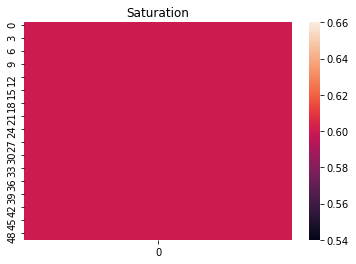

In [66]:
Satur_matrix = np.ones((nx, ny))  # ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.corner)
Satur_matrix *= 0.6
sns.heatmap(Satur_matrix)
plt.title("Saturation")
plt.show()

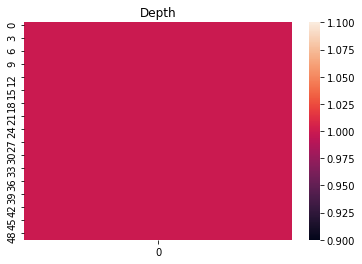

In [67]:
depth_matrix = np.ones((nx, ny))  # ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.centroid)
sns.heatmap(depth_matrix)
plt.title("Depth")
plt.show()

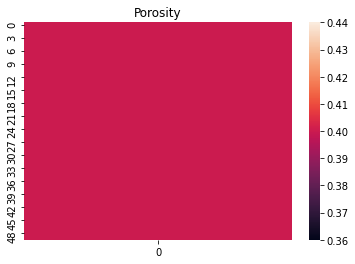

In [68]:
porosity_matrix = np.ones((nx, ny))  # ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.centroid)
porosity_matrix *= 0.4
sns.heatmap(porosity_matrix)
plt.title("Porosity")
plt.show()

$poirosity\leq 40\%$

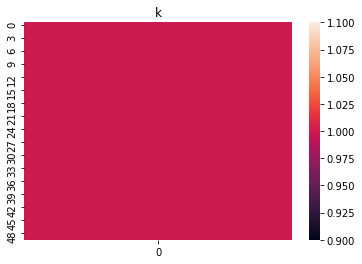

In [69]:
k_matrix = np.ones((nx, ny))  # ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.corner_1)
sns.heatmap(k_matrix)
plt.title("k")
plt.show()

Давления пусть будут одинаково распределены

In [70]:
dy = np.ones(ny) * const.dy()
dx = np.ones(nx) * const.dx()

p_vec = np.ones((nx*ny)).reshape((-1, 1)) * const.p_0()
S_o_vec = Satur_matrix.reshape((-1, 1))
S_w_vec = (np.ones(Satur_matrix.shape) - Satur_matrix).reshape((-1, 1))

Обозначем важные прмежуточные матрицы для 
$$\vec{p^{n+1}} = \vec{p^{n}} + \Delta t \big[B^{p, w}\big]^{-1}\big[ T^{upd}_{\tilde{k}} \vec{p} + \tilde{Q} + \frac{B_o}{B_w} q_o^{well} + q_w^{well}\big]$$

In [71]:
wells = {(20, 0): -1e-1,
         (30, 0): -1e-1
        }
neibours = [(32, 0)]

In [72]:
env = res.Env(k_2d_matrix=k_matrix, poir_2d_matrix=porosity_matrix, depth_2d_matrix=depth_matrix,
              satur_2d_matrix=Satur_matrix,
              const=const, well_positions=wells,
              boundary_cond = {'o': 'const_pressure', 'p': 'const_pressure', 'w': 'const_pressure'}
             )

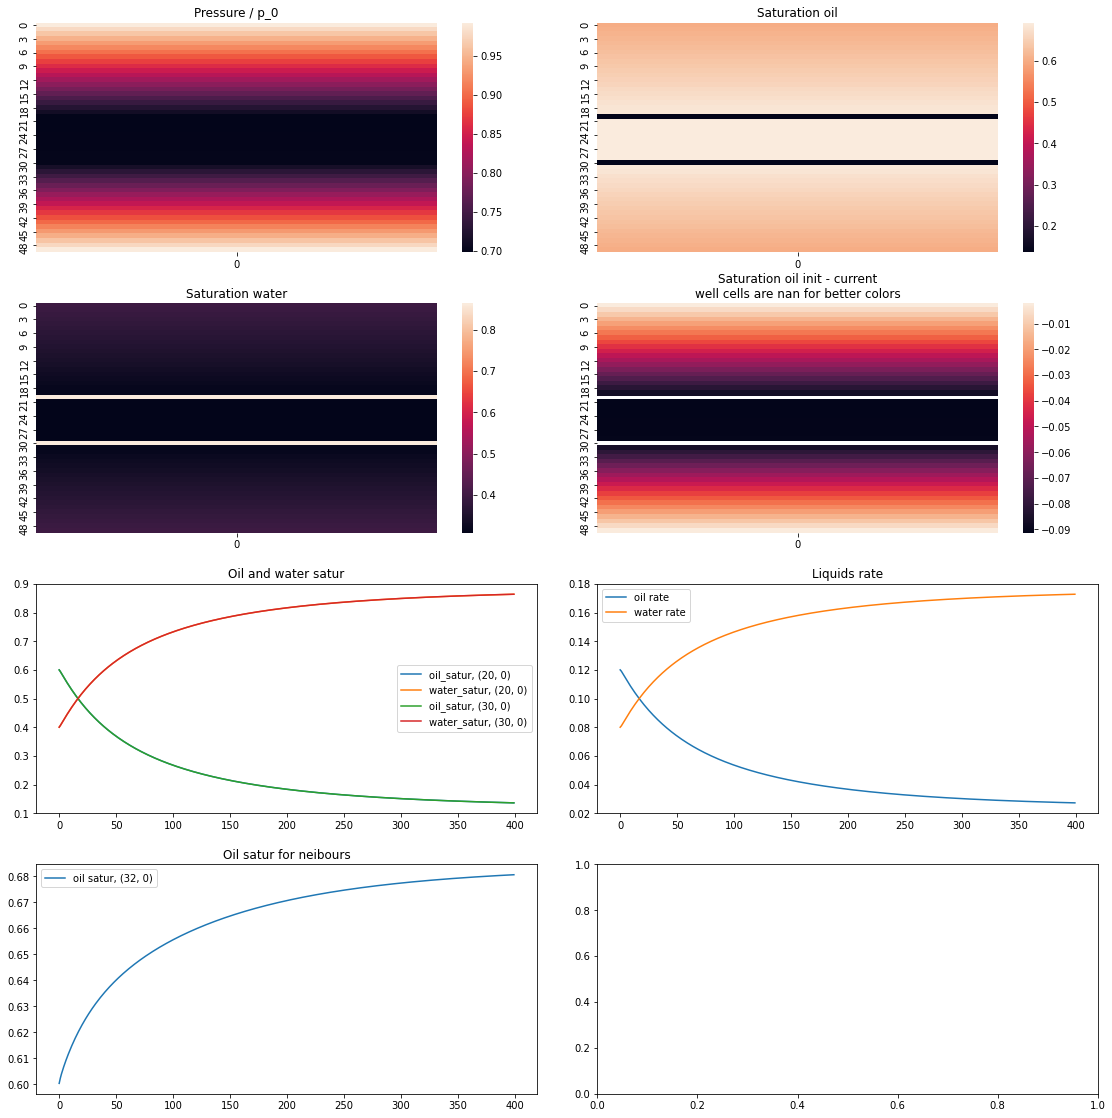

In [73]:
n_it = int(2e3)
upd_plot_freq = int(5e0)
q_o_rate = []
q_w_rate = []

s_o_hist = {key: [] for key in wells}
s_w_hist = {key: [] for key in wells}
for key in neibours:
    s_o_hist[key] = []
    s_w_hist[key] = []

for i in range(n_it):
    env.step()
    
    if i % upd_plot_freq == 0:
        
        s_o = env.s_o_as_2d()
        s_w = env.s_w_as_2d()
        q_w_rate.append(env.q_w_total())
        q_o_rate.append(env.q_o_total())

        for key in wells:
            s_o_hist[key].append(s_o[key[0], key[1]])
            s_w_hist[key].append(s_w[key[0], key[1]])
        
        for key in neibours:
            s_o_hist[key].append(s_o[key[0], key[1]])
            s_w_hist[key].append(s_w[key[0], key[1]])
        
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
        f.tight_layout(pad=3.0)
        g1 = sns.heatmap(env.p_as_2d() / const.p_0(), ax=ax[0][0], cbar=True) #, vmax=1, vmin=0.8)
        g1.set_title('Pressure / p_0')
        
        g2 = sns.heatmap(env.s_o_as_2d(), ax=ax[0][1], cbar=True) # , vmax=0.5, vmin=0.3)
        g2.set_title('Saturation oil')

        g3 = sns.heatmap(s_w, ax=ax[1][0], cbar=True) # , vmax=0.7, vmin=0.5)
        g3.set_title('Saturation water')
        satur_diff = Satur_matrix - s_o
        for key in wells:
            satur_diff[key] = np.nan
        g4 = sns.heatmap(satur_diff, cbar=True, ax=ax[1][1])#, vmax=1, vmin=0)
        g4.set_title('Saturation oil init - current\nwell cells are nan for better colors')
        
        # plot satur in every well
        for key in wells:
            ax[2][0].plot(s_o_hist[key], label=f'oil_satur, {key}')
            ax[2][0].plot(s_w_hist[key], label=f'water_satur, {key}')
        ax[2][0].set_title('Oil and water satur')
        ax[2][0].legend()
        
        ax[2][1].plot(q_o_rate, label='oil rate')
        ax[2][1].plot(q_w_rate, label='water rate')
        ax[2][1].set_title('Liquids rate')
        ax[2][1].legend()
        for key in neibours:
            ax[3][0].plot(s_o_hist[key], label=f'oil satur, {key}')
            ax[3][0].set_title('Oil satur for neibours')
            ax[3][0].legend()
        
        plt.show()